# Preprocessing & Modeling

In [1]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text 
import re
import nltk

# setting pandas settings to display additional rows within Jupyter Labs
pd.set_option('display.max_rows', 500)

In [2]:
# importing clean Reddit CSV 
reddit = pd.read_csv('./data/reddit_clean.csv')

In [3]:
# inspecting dtypes
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   num_comments  1929 non-null   int64 
 1   score         1929 non-null   int64 
 2   subreddit     1929 non-null   object
 3   title         1929 non-null   object
 4   is_nfl        1929 non-null   int64 
 5   date          1929 non-null   object
 6   clean_title   1929 non-null   object
 7   word_count    1929 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 120.7+ KB


In [4]:
#inspecting the DataFrame
reddit.head(2)

,num_comments,score,subreddit,title,is_nfl,date,clean_title,word_count
0,61,1,nfl,Lamar Jackson Hate,1,2021-10-01,lamar jackson hate,3
1,103,1,nfl,[Lombardi] 49ers continue advocating for a rul...,1,2021-10-01,lombardi 49ers continue advocating rule change...,49


In [5]:
# creating X from the cleaned Reddit post titles
X = reddit['clean_title']

In [6]:
# creating y from 'is_nfl' column. 1 = NFL, 0 = fantasyfootball
y = reddit['is_nfl']

In [7]:
# train test split with random state
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=48)

In [8]:
# creating additional stop words
extra_stop_words = pd.array(['morning', 'fantasy', 'nfl'])

---

## Attempt One: Logistic Regression with GridSearch

In [9]:
# pipe with logistic regression and countvectorizer
cvect_pipe = make_pipeline(CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words), max_features = 300),
                           LogisticRegression(max_iter=1000, random_state=48))

In [10]:
# grid searching across ngram ranges
params = {'countvectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,3)]}

In [11]:
# creating grid, fitting to test data
cvect_grid = GridSearchCV(cvect_pipe, params, n_jobs =-1)
cvect_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=300,
                                                        stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'alm

In [12]:
# creating predictions from training data
preds = cvect_grid.predict(X_test)

In [13]:
# accuracy score on test set
cvect_grid.score(X_test, y_test)

0.7929606625258799

In [14]:
# accuracy score on training set, slight overfitting
cvect_grid.score(X_train, y_train)

0.8796680497925311

In [15]:
# pulling best parameters from gridsearch
cvect_grid.best_params_

{'countvectorizer__ngram_range': (1, 1)}

### Logistic Regression Coefficients

In [16]:
# creating a dataframe from the coefficients and feature names
coefs = cvect_grid.best_estimator_.named_steps['logisticregression'].coef_

word_coefs = pd.DataFrame({'words': cvect_grid.best_estimator_.named_steps['countvectorizer'].get_feature_names_out(), 
              'coefs': coefs[0]})

In [17]:
# creating a variable for words with highest coefficients (indicating NFL)
top_words = word_coefs.sort_values(by='coefs', ascending=False).head(10)

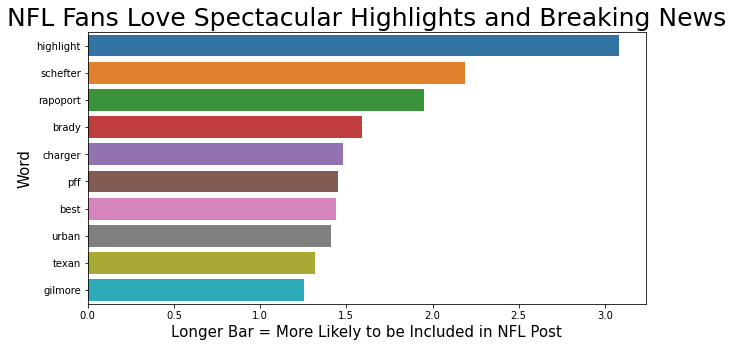

In [18]:
#plotting highest coefficient words in bar chart and saving figure for use in executive summary
plt.figure(figsize = (10,5))
sns.barplot(x = top_words['coefs'], y = top_words['words'])
plt.title('NFL Fans Love Spectacular Highlights and Breaking News', fontsize = 25)
plt.xlabel('Longer Bar = More Likely to be Included in NFL Post', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Word', fontsize = 15)
plt.savefig('./charts/nflcoef');

In [19]:
# creating a variable for words with lowest coefficients (indicating fantasyfootball)
bottom_words = word_coefs.sort_values(by='coefs', ascending=False).tail(10)

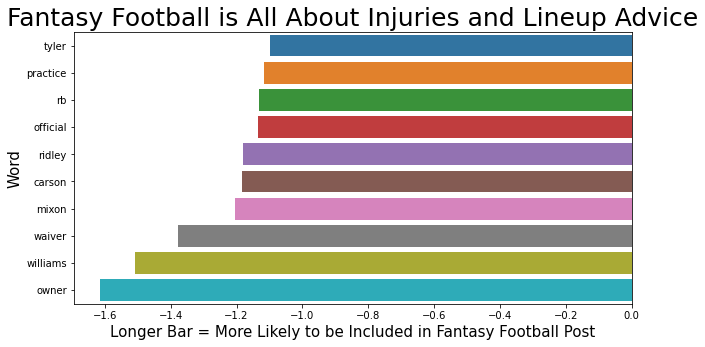

In [20]:
# plotting negative coefficient words in bar chart and saving figure for use in executive summary
plt.figure(figsize = (10, 5))
sns.barplot(x = bottom_words['coefs'], y = bottom_words['words'])
plt.title('Fantasy Football is All About Injuries and Lineup Advice', fontsize = 25)
plt.xlabel('Longer Bar = More Likely to be Included in Fantasy Football Post', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Word', fontsize = 15)
plt.savefig('./charts/ffcoef');

---

## Attempt Two: Random Forest

In [21]:
# create pipe with random forest and countvectorizer
forest_pipe = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 300),
                           RandomForestClassifier(random_state=48))

In [22]:
# grid searching across ngram ranges
params = {'countvectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,3)]}

In [23]:
# creating gridsearch and fitting to training data
forest_grid = GridSearchCV(forest_pipe, params, n_jobs =-1)
forest_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=300,
                                                        stop_words='english')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=48))]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (2, 3)]})

In [24]:
# predictions for the test set
preds = forest_grid.predict(X_test)

In [25]:
# accuracy score for the test set
forest_grid.score(X_test, y_test)

0.772256728778468

In [26]:
# accuracy score for the training set, pretty heavy overfitting
forest_grid.score(X_train, y_train)

0.9764868603042877

In [27]:
# pulling best parameters from gridsearch
forest_grid.best_params_

{'countvectorizer__ngram_range': (1, 1)}

---

## Attempt Three: Gradient Boosting

In [28]:
# pipe with gradient boosting and countvectorizer
boost_pipe = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 1000),
                           GradientBoostingClassifier(random_state = 48))

In [29]:
# grid searching across ngram ranges
params = {'countvectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,3)]}

In [30]:
# creating a gridsearch and fitting to training data
boost_grid = GridSearchCV(boost_pipe, params, n_jobs =-1)
boost_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=1000,
                                                        stop_words='english')),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=48))]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (2, 3)]})

In [31]:
# predictions for test set
preds = boost_grid.predict(X_test)

In [32]:
# accuracy score on the test data
boost_grid.score(X_test, y_test)

0.8115942028985508

In [33]:
# accuracy score on the training data
boost_grid.score(X_train, y_train)

0.8734439834024896

In [34]:
# pulling best parameters from the grid search
boost_grid.best_params_

{'countvectorizer__ngram_range': (1, 3)}

### Analyzing Predict Probas

In [35]:
# inspiration from https://stackoverflow.com/questions/48947194/add-randomforestclassifier-predict-proba-results-to-original-dataframe
prediction_of_probability = boost_grid.predict_proba(X_test)

# pulling prediction probabilities and inserting into dataframe along with X_test data and targets
df_test = pd.DataFrame(X_test)
df_test['Target'] = y_test
df_test['prob_0'] = prediction_of_probability[:,0] 
df_test['prob_1'] = prediction_of_probability[:,1]

In [36]:
# showing observations with the highest prediction of r/fantasyfootball
df_test.sort_values(by = 'prob_0', ascending = False).head(10)

,clean_title,Target,prob_0,prob_1
1861,official wdis rb sun morning 10 10 2021,0,0.946304,0.053696
1762,official wdis rb sat morning 10 09 2021,0,0.946304,0.053696
1090,official wdis rb sat evening 10 02 2021,0,0.932765,0.067235
1016,official wdis rb fri evening 10 01 2021,0,0.932765,0.067235
1161,official wdis wr sun morning 10 03 2021,0,0.932678,0.067322
1053,official wdis flex sat morning 10 02 2021,0,0.932678,0.067322
969,official wdis flex fri morning 10 01 2021,0,0.932678,0.067322
1667,official add drop fri morning 10 08 2021,0,0.932678,0.067322
1271,official add drop mon morning 10 04 2021,0,0.932678,0.067322
1477,official wednesday weekly trade value wed morn...,0,0.932678,0.067322


In [37]:
# showing observations with the highest prediction of r/NFL
df_test.sort_values(by = 'prob_1', ascending = False).head(10)

,clean_title,Target,prob_0,prob_1
193,schefter bucs quarterback tom brady set nfl ti...,1,0.011925,0.988075
379,highlight j herbert pas short middle parham 4 ...,1,0.026737,0.973263
554,urban meyer disastrous head coach hire nfl his...,1,0.030078,0.969922
297,highlight tom brady get sacked matt judon 8 ya...,1,0.031135,0.968865
174,tom brady tampa bay buccaneer defeat new engla...,1,0.032239,0.967761
898,highlight big ben 50 yard bomb diontae td,1,0.035694,0.964306
285,highlight brady pass drew brees career pas yar...,1,0.038843,0.961157
701,highlight geno smith ball picked,1,0.039415,0.960585
381,highlight charger called facemask,1,0.046503,0.953497
402,highlight charger wit da pooch punt v raider r...,1,0.046503,0.953497


In [38]:
# Create CSV from final DF
df_test.to_csv('./data/reddit_predict_proba.csv')

---

## Attempt Four: Bayes

In [39]:
# creating pipe with naive bayes and countvectorizer
bayes_pipe = make_pipeline(CountVectorizer(stop_words = 'english', max_features = 300),
                           MultinomialNB())

In [40]:
# gridsearching across ngram ranges
params = {'countvectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,3)]}

In [41]:
# creating gridsearch and fitting to training data
bayes_grid = GridSearchCV(bayes_pipe, params, n_jobs =-1)
bayes_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=300,
                                                        stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (2, 3)]})

In [42]:
# creating predictions for test data
preds = bayes_grid.predict(X_test)

In [43]:
# accuracy score for test data
bayes_grid.score(X_test, y_test)

0.7888198757763976

In [44]:
# accuracy score for training data
bayes_grid.score(X_train, y_train)

0.843015214384509

In [45]:
# pulling best parameters from gridsearch
bayes_grid.best_params_

{'countvectorizer__ngram_range': (1, 1)}